In [1]:
import os
print(os.getcwd())

c:\Users\andpa\Desktop\TimeVQVAE-main


In [2]:
#@title Define your Paths (set yours)
#can find your path going on the "folder image" on the left,
#navigating your drive till the project folder, then selecting "copy path" in the "3dots menu" u.u
DIR_PATH = ''
MODEL_PATH = '' # 'timeVQVAE/TimeVQVAE-main'

In [3]:
#@title Check Them
#just a check u're not messin up: u should see the list of your folder's descendants O.ò
print(os.listdir(os.path.join(os.getcwd(),DIR_PATH)))
print('-------')
print(os.listdir(os.path.join(os.getcwd(),MODEL_PATH)))

['.fig', '.gitignore', '.google_colab', 'configs', 'datasets', 'encoder_decoders', 'evaluate.py', 'evaluation', 'experiments', 'generators', 'LICENSE', 'lightning_logs', 'MyExample_TimeVQVAE.ipynb', 'preprocessing', 'README.md', 'requirements.txt', 'results', 'run_CAS.py', 'saved_models', 'stage1.py', 'stage12_all_ucr.py', 'stage2.py', 'utils', 'vector_quantization', 'venv_timevqvae', '__pycache__']
-------
['.fig', '.gitignore', '.google_colab', 'configs', 'datasets', 'encoder_decoders', 'evaluate.py', 'evaluation', 'experiments', 'generators', 'LICENSE', 'lightning_logs', 'MyExample_TimeVQVAE.ipynb', 'preprocessing', 'README.md', 'requirements.txt', 'results', 'run_CAS.py', 'saved_models', 'stage1.py', 'stage12_all_ucr.py', 'stage2.py', 'utils', 'vector_quantization', 'venv_timevqvae', '__pycache__']


In [4]:
#@title Install HERE! (set yours)
#added wget in requirements.txt just before supervised_fcn because it downloads an older version instead
#!pip install -r 'timeVQVAE/TimeVQVAE-main/requirements.txt'

#import subprocess
#import sys
#
#requirements_path = os.path.join(os.getcwd(),'requirements.txt') 
#
#subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', requirements_path])

In [5]:
#@title Import HERE!
import torch
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True
import matplotlib.pyplot as plt
import os

In [6]:
#@title Add the Model folder to the Path to allow Imports
import sys
sys.path.append(os.path.join(os.getcwd(),MODEL_PATH))

In [7]:
import numpy as np

print("My numpy version is: ", np.__version__)


My numpy version is:  1.26.4


# VQVAE

### Training With Kuka Dataset

In [8]:
#@title Import stage1, stage2, evaluate
# Just putting the scripts from these modules in a notebook format
from stage1 import *
#from stage2 import *
#from evaluate import *
from utils import *
#dataset_names = ['FordA']
config = load_yaml_param_settings(os.path.join(MODEL_PATH, 'configs/config.yaml'))
gpu_device_idx = 0

In [9]:
#dropping_col1 = ['af1__5', 'af1__10', 'af1__22', 'af1__26', 'af1__30', #5
#                 'f__10', 'f__15', 'f__26', 'f__36', 'f__90',  #10
#                 'f__91', 'f__98', 'f__104', 'f__120', 'f__122', #15
#                 'f__127', 'f__129', 'f__140', 'f__152', 'f__153', #20
#                 'f__154', 'f__158', 'f__169', 'f__170', 'f__172', #25
#                 'f__173', 'f__174', 'f__175', 'f__176', 'f__177', #30
#                 'f__178', 'f__188', 'f__198', 'f__199', 'f__203', #35
#                 'f__207', 'f__214', 'f__215', 'f__219', 'f__228', #40
#                 'f__231', 'f__236'] #42

In [10]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
#from sklearn.utils.class_weight import compute_class_weight
from datasets.kuka_dataset.KukaDataset import KukaDataset
from tqdm import tqdm

dataset_name = 'KUKA'
TRAIN_DATA_PATH = "datasets/kuka_dataset/normal"
TEST_DATA_PATH = "datasets/kuka_dataset/collisions"

#import random
#onlyfiles = pd.read_csv(os.path.join(os.getcwd(),TRAIN_DATA_PATH))
## dropping columns...
##onlyfiles.drop(dropping_col1, axis=1, inplace=True)
#
##splitting train and val...
#grouped = list(onlyfiles.groupby("ChassisId_encoded"))
#random.shuffle(grouped)
#train_ratio = 0.8
#split_index = int(len(grouped) * train_ratio)
## ...or maybe not if u train for testing...
#train_groups = grouped #grouped[:split_index] 
#validation_groups = grouped #grouped[split_index:]

categories = np.array(['Low', 'High']).reshape(-1, 1)
encoder = OneHotEncoder(dtype=np.float32)
encoder.fit(categories)

train_dataset = KukaDataset(os.path.join(os.getcwd(),TRAIN_DATA_PATH), test=False, config=config, keep_faulty=False, risk_encoder=encoder)
val_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=False, config=config, columns_to_keep=train_dataset.kept_columns, risk_encoder=encoder)
#test_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=True, config=config, columns_to_keep=train_dataset.kept_columns)

config['dataset']['in_channels'] = len(train_dataset.kept_columns) - len(train_dataset.header_columns)

files were read...
risk_level column added...
--- Train Dataset ---
preprocessing ... 
Dropping all NaN columns across all windows
Dropping all static columns across all windows
df len is: 15000 window shape is: (25, 70)
files were read...
risk_level column added...
start adding high risk
found the excel and loaded it...
end adding high risk
--- Train Dataset ---
preprocessing ... 
Dropping all NaN columns across all windows
Dropping all static columns across all windows
df len is: 15000 window shape is: (25, 70)


In [ ]:
#t_list.shape, v_list.shape, config['dataset']['in_channels'] # yeah, it's fine for in channels to be less 
                                                             # because dataset get item drops other columns
print(val_dataset.targets[10000:10150])

In [11]:
#@title stage1.py script
# input to model forward is a tensor (B, C, L) batch, feats, window_timestamp 

batch_size = config['dataset']['batch_sizes']['stage1']

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, collate_fn = KukaDataset.padding_collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=1)#, collate_fn = KukaDataset.padding_collate_fn)
#test_data_loader =  DataLoader(test_dataset, batch_size=1)#, collate_fn = KukaDataset.padding_collate_fn)


In [12]:
# train
#train_stage1(config, dataset_name, train_data_loader, val_data_loader, gpu_device_idx, do_validate=False)
train_stage1(config, dataset_name, train_data_loader, val_data_loader, gpu_device_idx=None, do_validate=False, accelerator=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\andpa\Desktop\TimeVQVAE-main\venv_timevqvae\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
c:\Users\andpa\Desktop\TimeVQVAE-main\venv_timevqvae\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name     

Epoch 0:   0%|          | 0/118 [00:00<?, ?it/s] 

c:\Users\andpa\Desktop\TimeVQVAE-main\venv_timevqvae\Lib\site-packages\torch\functional.py:665: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ..\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
c:\Users\andpa\Desktop\TimeVQVAE-main\utils\__init__.py:228: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ..\aten\src\ATen\native\SpectralOps.cpp:1

Epoch 1: 100%|██████████| 118/118 [01:43<00:00,  1.15it/s, loss=4.24e+06, v_num=11]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 118/118 [01:43<00:00,  1.15it/s, loss=4.24e+06, v_num=11]
closing...
saving the models...


In [13]:
from experiments.exp_vq_vae import ExpVQVAE
exp_vqvae = ExpVQVAE(config['trainer_params']['input_length'], config, len(train_data_loader.dataset))

models_dir = 'saved_models'
#models_dir = 'saved_models_200ep'
#models_dir = 'saved_models_1000ep'
#models_dir = 'saved_models_1000ep_dcol1'

# load
fname = f'vq_model_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.vq_model_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'vq_model_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.vq_model_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.encoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.encoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.decoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.decoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)

exp_vqvae.eval()

ExpVQVAE(
  (encoder_l): VQVAEEncoder(
    (encoder): Sequential(
      (0): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(140, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (1): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ResBlock(
   

In [14]:
# KEEP BATCH SIZE = 1 HERE, PLEASE
mapping = {0: 'Low', 1: 'High'}
all_losses = []
window_label_pos = config['trainer_params']['input_length'] - 1
for batch in tqdm(val_data_loader): #iterating through test ds with step B
    
    x , y = batch[0], batch[1]
    #x = x.to(gpu_device_idx) #comment if using the CPU
    
    recons_loss, vq_losses, perplexities = exp_vqvae.forward((x,))

    loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
            recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
            vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
            recons_loss['perceptual']

    curr_label = mapping[torch.argmax(y[0, :, window_label_pos]).item()]

    all_losses.append((loss.detach().item(), curr_label))

100%|██████████| 15000/15000 [04:57<00:00, 50.42it/s] 


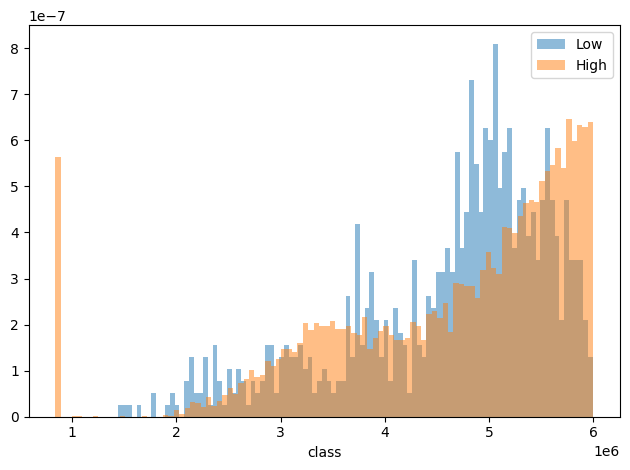

In [19]:
bins=100
alpha=.5
max_x_axes = 6_000_000
plt.figure()
lows = [loss for loss, lb in all_losses if lb == 'Low' and loss <= max_x_axes]
highs = [loss for loss, lb in all_losses if lb == 'High' and loss <= max_x_axes]
#print(len(lows), len(highs))
plt.hist(lows, bins = bins, density = True, alpha = alpha, label = 'Low')
plt.hist(highs, bins = bins, density = True, alpha = alpha, label = 'High')
plt.xlabel('class')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
from sklearn import svm

X = np.array([ls for ls, lb in all_losses]).reshape(-1, 1)

# Map labels to numeric values
label_map = {'Low': 0, 'High': 1}
y_numeric = np.array([label_map[lb] for ls, lb in all_losses])

# Train SVM model
clf = svm.SVC(kernel='linear', C=1.0)  # Gotta try different C
clf.fit(X, y_numeric)

# Extract threshold (decision function distance)
threshold = -clf.intercept_[0] / clf.coef_[0][0]

print(f"Soft margin threshold: {threshold}")


In [ ]:
# KEEP BATCH SIZE = 1 HERE, PLEASE

window_label_pos = config['trainer_params']['input_length'] - 1
all_preds = []
for batch in test_data_loader: #iterating through test ds with step B
    x = batch[0]
    x = x.to(gpu_device_idx)
    preds = ["Low"] 
    
    recons_loss, vq_losses, perplexities = exp_vqvae.forward((x,))
        
    loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
            recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
            vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
            recons_loss['perceptual']
    
    mask_gt_low = (loss > threshold)

    if mask_gt_low:
        preds= ["High"] 
              
    all_preds.append(preds)

In [176]:
all_preds

[['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',

In [177]:
df_pred = pd.DataFrame(data=np.ravel(all_preds), columns=['pred'])
df_pred.to_csv(os.path.join(DIR_PATH,'SampleSubmission/prediction.csv'), index=False)